# EIGSEP Suspension and Horizon Modeling

Aaron Parsons

In [1]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib.colors import LightSource
from mayavi import mlab
# eigsep_terrain is available at https://github.com/AaronParsons/eigsep_terrain.git
from eigsep_terrain.marjum_dem import MarjumDEM as DEM
import eigsep_terrain as et
import linsolve
mlab.init_notebook()

%matplotlib widget

Notebook initialized with ipy backend.


In [2]:
CACHE_FILE = 'marjum_dem.npz'
dem = DEM(cache_file=CACHE_FILE)

In [3]:
# Survey points from July 2024 site
SURVEY_PNTS = {
    'A': '+039.241127, -113.392966, 1748',  # ~3m south of antenna 1
    'B': '+039.239895, -113.395416, 1728',  # ~3m south of antenna 2
    'O': '+039.241514, -113.395236, 1804',  # outlook, west canyon
    'W': '+039.241107, -113.395233, 1790',  # anchor, west
    'E': '+039.240712, -113.393846, 1776',  # anchor, east
}

dem.add_survey_points(SURVEY_PNTS)
# interpolate an estimated point for where the July 2024 antenna was suspended
dem['M'] = dem.interp_alt(*((dem['W'] + dem['E'])[:2] / 2), return_vec=True)

dem['P'] = dem.interp_alt(1644, 2032, return_vec=True)  # site 1
#dem['P'] = dem.interp_alt(1744, 2262, return_vec=True)  # site 2
#dem['P'] = dem['M']  # July 2024 site

crds = None

In [4]:
R = 100 # m, standoff radius for antenna

e0, n0, u0 = dem['P']

# Search an area for a low antenna spot, solving for the height it needs to be off the ground
_e0_rng = np.arange(e0 - 50, e0 + 50, 2)
_n0_rng = np.arange(n0 - 50, n0 + 50, 2)

hs = []
for _n0 in _n0_rng:
    hs.append([])
    for _e0 in _e0_rng:
        E, N, U = dem.get_tile(erng_m=(_e0-R, _e0+R), nrng_m=(_n0-R, _n0+R))
        h2s = R**2 - (E - _e0)**2 - (N - _n0)**2
        _u0 = dem.interp_alt(_e0, _n0)
        # XXX is this equation right?
        h = np.max(np.where(h2s > 0, U - _u0 + np.sqrt(np.clip(h2s, 0, np.Inf)), 0))
        hs[-1].append((h, h+_u0))
hs = np.array(hs)
print(hs.shape)

(50, 50, 2)


In [5]:
def color_str2tup(s):
    r, g, b = s[0:2], s[2:4], s[4:6]
    return tuple(map(lambda x: int(x, base=16) / 255, (r, g, b)))

def plot_img(ax, data, res=dem.res, xlabel=True, ylabel=True,
             colorbar=False, cmap='terrain', erng=None, nrng=None, **kw):
    '''Plot maps with standard format.'''
    if nrng is None:
        nrng = (0, data.shape[0] * res)
    if erng is None:
        erng = (0, data.shape[1] * res)
    extent = erng + nrng
    im = ax.imshow(data, extent=extent, cmap=cmap, origin='lower', interpolation='nearest', **kw)
    if colorbar:
        plt.colorbar(im)
    if xlabel:
        ax.set_xlabel('East [m]')
    if ylabel:
        ax.set_ylabel('North [m]')

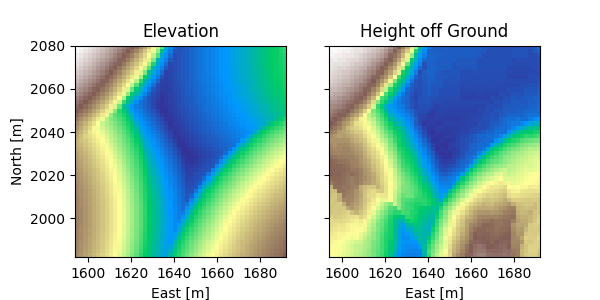

In [6]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(6, 3))
plot_img(axes[0], hs[..., 1],  erng=(_e0_rng[0], _e0_rng[-1]), nrng=(_n0_rng[0], _n0_rng[-1]))
axes[0].set_title('Elevation')
plot_img(axes[1], hs[..., 0], res=2, ylabel=False, erng=(_e0_rng[0], _e0_rng[-1]), nrng=(_n0_rng[0], _n0_rng[-1]))
_ = axes[1].set_title('Height off Ground')

In [7]:
def dist(a, b):
    return np.linalg.norm(b - a)

def alt(a, b):
    return b[-1] - a[-1]

def az(a, b):
    return np.arctan2(b[1] - a[1], b[0] - a[0])

In [8]:
# solve for good tether points around antenna location
MAX_H = 115 # m, maximum antenna height off ground
THETA_MIN = np.deg2rad(20) # radians, minimum tether inclination angle
N_BINS = 256  # number of azimuthal bins to group pixels into for finding opposing tether points
view_rng = 400 # m
TETHER_MAX = 300 # m, absolute maximum for tether length; don't consider longer than this

# pick a minimum altitude after selecting for low antenna height off ground
h = hs[...,1][hs[...,0] <= MAX_H].min()
_n0, _e0 = np.where(hs[...,1] == h)
h = hs[_n0, _e0, 0][0]
e0, n0 = _e0_rng[_e0][0], _n0_rng[_n0][0]
dem['P'] = dem.interp_alt(e0, n0, return_vec=True) + np.array([0, 0, h])
e0, n0, u0 = pltfm = dem['P']
print(f'Best location: {e0: 3.0f} m East, {n0: 3.0f} m North, {u0: 3.0f} m Up ({h: 3.0f} m off ground)')

# Find tether points
anchors, boundaries = dem.find_anchors(e0, n0, u0, n_anchors=2, r_anchor_max=TETHER_MAX)
dem['X'] = anc_e = dem.interp_alt(*anchors[0], return_vec=True)
dem['Y'] = anc_w = dem.interp_alt(*anchors[1], return_vec=True)

print(f"Distance to Anchor 1 = {dist(pltfm, anc_e): 3.0f} m, Extended length = {dist(pltfm - h, anc_e): 3.0f} m")
print(f"Distance to Anchor 2 = {dist(pltfm, anc_w): 3.0f} m, Extended length = {dist(pltfm - h, anc_w): 3.0f} m")

Best location:  1644 m East,  2032 m North,  1793 m Up ( 110 m off ground)
Distance to Anchor 1 =  259 m, Extended length =  361 m
Distance to Anchor 2 =  239 m, Extended length =  321 m


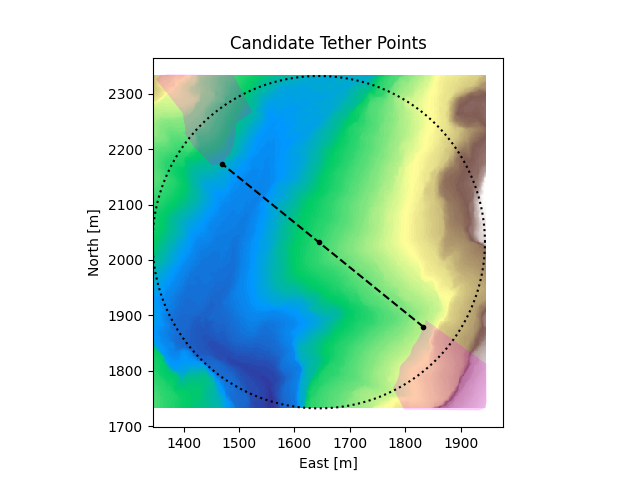

In [9]:
fig, ax = plt.subplots()
e1, n1 = anchors[0]
e2, n2 = anchors[1]
erng = (e0 - TETHER_MAX, e0 + TETHER_MAX)
nrng = (n0 - TETHER_MAX, n0 + TETHER_MAX)
plot_img(ax, U, erng=erng, nrng=nrng)
plt.plot([e0, e1, e2], [n0, n1, n2], 'k.')
plt.plot([e1, e2], [n1, n2], 'k--')
th = np.linspace(0, 2 * np.pi, 200)
_r = 300
plt.plot(e0 + _r * np.cos(th), n0 + _r * np.sin(th), 'k:')

for cnt in range(len(anchors)):
    ax.fill(boundaries[cnt, :, 0], boundaries[cnt, :, 1], 'magenta', alpha=0.2)
_ = plt.title('Candidate Tether Points')

In [10]:
# Calculate the horizon angle of the terrain surround the antenna
horizon_angles, crds = dem.calc_horizon(e0, n0, u0, crds=crds)
vis_dist = et.utils.horizon_angle_to_distance(horizon_angles, 10e3)
print(f'Estimated Viewable Airplane Area {np.sum(np.pi * vis_dist ** 2 / vis_dist.size) / 1e6:3.0f} km^2')

Estimated Viewable Airplane Area 13698 km^2


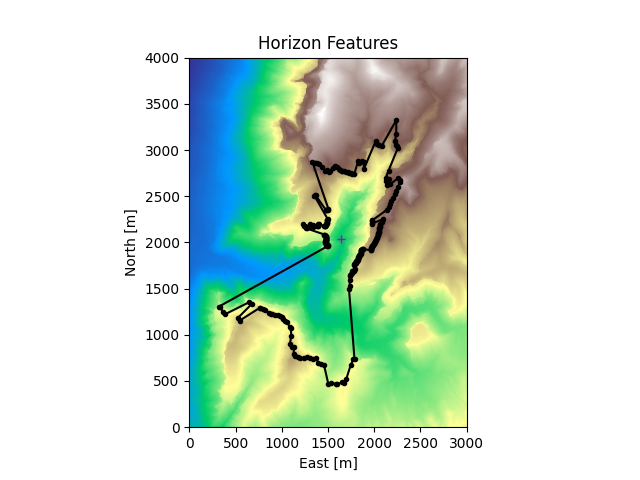

In [11]:
fig, ax = plt.subplots()
plot_img(ax, dem.data, dem.res)
plt.plot(crds[1], crds[0], 'k.-')
plt.plot([e0], [n0], 'm+')
_ = plt.title('Horizon Features')

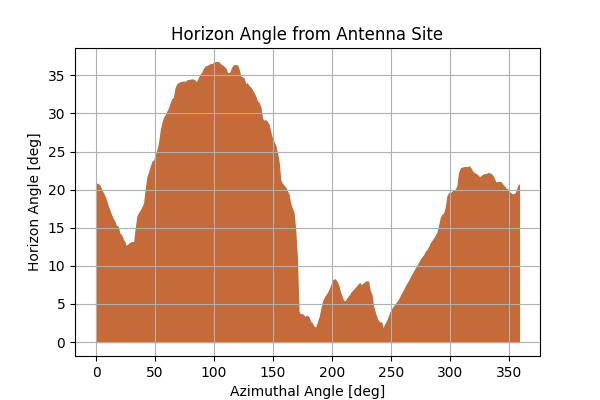

In [12]:
plt.figure(figsize=(6,4))
plt.title('Horizon Angle from Antenna Site')
plt.fill_between(np.linspace(0, 360, horizon_angles.size, endpoint=False), np.rad2deg(horizon_angles), 0, color=color_str2tup('c56a39'))
plt.xlabel('Azimuthal Angle [deg]')
plt.ylabel('Horizon Angle [deg]')
_ = plt.grid()

In [18]:
E, N, U = dem.get_tile(erng_m=(e0 - view_rng, e0 + view_rng), nrng_m=(n0 - view_rng, n0 + view_rng))

if True:  # enable 3d interactive plot
    TAUPE = color_str2tup('b7c0c9')
    mlab.figure(size=(2*400, 2*320), bgcolor=TAUPE)
    s = mlab.surf(E.T, N.T, U.T, warp_scale=1, vmin=1500, colormap='copper')
    mlab.outline()
    mlab.axes(xlabel='E', ylabel='N', zlabel='U')
    line1 = np.array([anc_e, pltfm])
    line2 = np.array([anc_w, pltfm])
    mlab.plot3d(line1[:,0], line1[:,1], line1[:,2], tube_radius=1)
    mlab.plot3d(line2[:,0], line2[:,1], line2[:,2], tube_radius=1)
    mlab.points3d(*pltfm, color=(1, 0, 1), opacity=0.3, scale_factor=2*R, resolution=64)
    mlab.view(250, 90)
    #mlab.view(270, 0)
else:
    s = None
s

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x02\x80\x08\x02\x00\x00\x00\xeby\x8be\x…

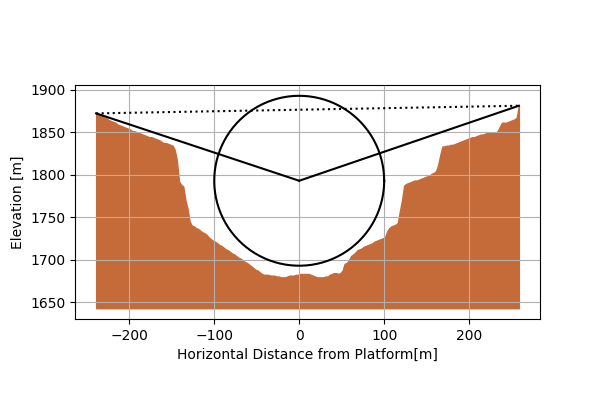

In [14]:
fig, axes = plt.subplots(figsize=(6, 4))
plot_e = np.linspace(anc_w[0], anc_e[0], 200)
plot_n = np.linspace(anc_w[1], anc_e[1], 200)
plot_r = np.linspace(-dist(anc_w, pltfm), dist(anc_e, pltfm), 200)
plt.fill_between(plot_r, dem.interp_alt(plot_e, plot_n), pltfm[-1] - 150, color=color_str2tup('c56a39'))
plt.plot([plot_r[0], plot_r[-1]], [anc_w[-1], anc_e[-1]], 'k:')
plt.plot([plot_r[0], 0], [anc_w[-1], pltfm[-1]], 'k-')
plt.plot([0, plot_r[-1]], [pltfm[-1], anc_e[-1]], 'k-')
th = np.linspace(0, 2 * np.pi, 200)
axes.plot(R * np.cos(th), pltfm[-1] + R * np.sin(th), 'k-')
plt.grid()
plt.xlabel('Horizontal Distance from Platform[m]')
plt.ylabel('Elevation [m]')
axes.set_aspect('equal')

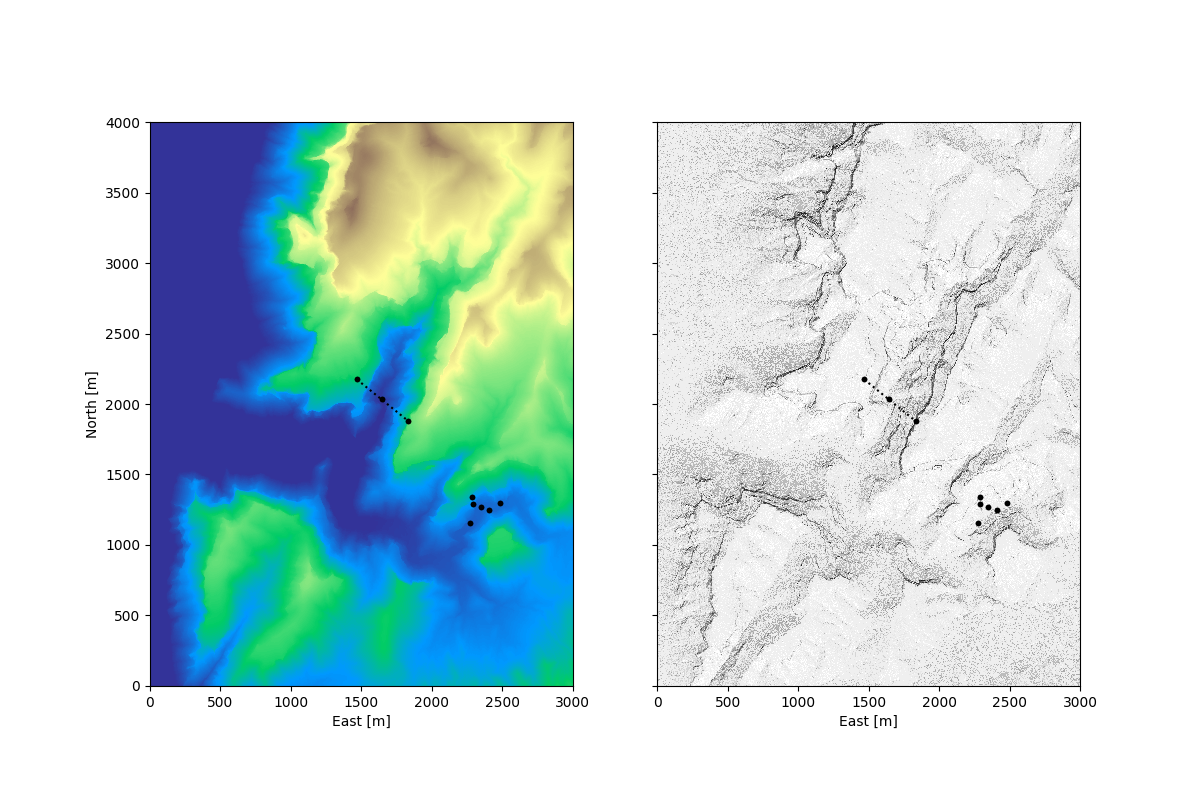

In [15]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12, 8))
plot_img(axes[0], dem.data, vmin=1670, vmax=2500)
ls = LightSource(azdeg=15, altdeg=65)
plot_img(axes[1], ls.hillshade(dem.data, vert_exag=1), cmap='gray', ylabel=False)

for ax in axes:
    ax.plot(plot_e, plot_n, 'k:')

for k, (_e, _n, _u) in dem.items():
    for ax in axes:
        ax.plot([_e], [_n], 'k.')
        ax.plot([_e], [_n], 'k.')

## Suspension Tethers

In this section we consider anchor points for suspending antennas at the two candidate sites.

The choice of minimum suspension angle impacts where anchors can be placed, but as suspension angles get flatter, increased force is required to hold an antenna platform of a fixed weight:
\begin{equation}
F_{\rm tension} = \frac{mg}{N_{\rm tethers}\sin\phi},
\end{equation}
where $N_{\rm tethers}$ is the number of tethers holding the antenna platform, and $\phi$ is the suspension angle.

In [16]:
units = 'kg'
platform_wgt = 50 # kg
rope_wgt = 20 # kg
tiedown_wgt = 10 # kg
total_wgt = platform_wgt + rope_wgt + 4 * tiedown_wgt

phi_w = np.arcsin(alt(pltfm, anc_w) / dist(anc_w, pltfm))
phi_e = np.arcsin(alt(pltfm, anc_e) / dist(anc_e, pltfm))

d = {}
d['Tw*sw + Te*se'] = total_wgt
d['Tw*cw - Te*ce'] = 0

consts = {
    'sw': np.sin(phi_w),
    'se': np.sin(phi_e),
    'cw': np.cos(phi_w),
    'ce': np.cos(phi_e),
}

ls = linsolve.LinearSolver(d, **consts)
ans = ls.solve()
print(ans)
print(phi_w, phi_e)

{'Tw': 163.08575074340968, 'Te': 163.689784952221}
0.3381522044680255 0.34849376966288187


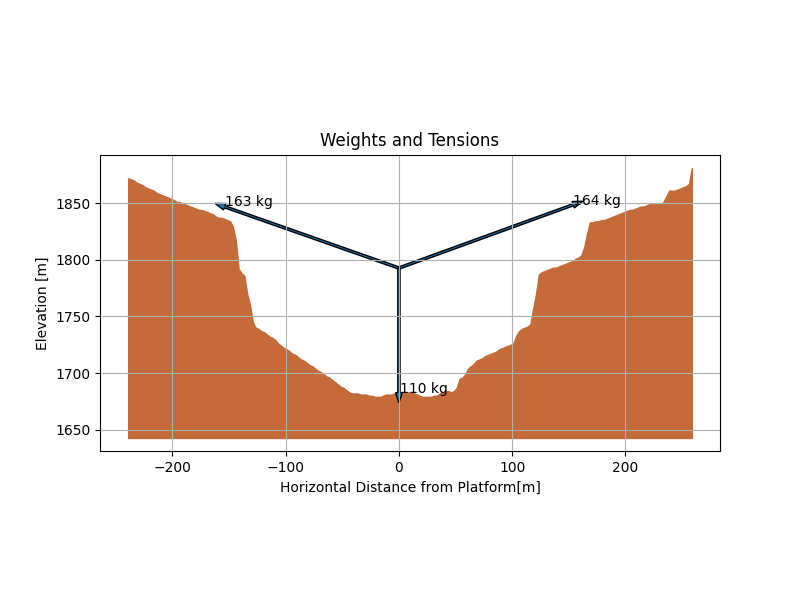

In [17]:
fig, axes = plt.subplots(figsize=(8, 6))
plt.fill_between(plot_r, dem.interp_alt(plot_e, plot_n), pltfm[-1] - 150, color=color_str2tup('c56a39'))
plt.arrow(0, pltfm[-1], -ans['Tw'] * np.cos(phi_w), ans['Tw'] * np.sin(phi_w), width=2)
plt.text(-ans['Tw'] * np.cos(phi_w), 1 + pltfm[-1] + ans['Tw'] * np.sin(phi_w), f'{ans["Tw"]:3.0f} {units}', fontsize=10)
plt.arrow(0, pltfm[-1],  ans['Te'] * np.cos(phi_e), ans['Te'] * np.sin(phi_e), width=2)
plt.text( ans['Te'] * np.cos(phi_e), 1 + pltfm[-1] + ans['Te'] * np.sin(phi_w), f'{ans["Te"]:3.0f} {units}', fontsize=10)
plt.arrow(0, pltfm[-1], 0, -total_wgt, width=2)
plt.text(1, pltfm[-1] - total_wgt, f'{total_wgt:3.0f} {units}', fontsize=10)
plt.grid()
plt.xlabel('Horizontal Distance from Platform[m]')
plt.ylabel('Elevation [m]')
axes.set_aspect('equal')
_ = plt.title('Weights and Tensions')

### Rope Specs
Typical 1/4" Kevlar rope (e.g. https://www.e-rigging.com/_p_3281.html) has a minimum breaking load of 470 kg,
weighs 3.4 kg per 100 m, and costs $40 per 100m.